In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/Nova Ims/Computational Finance/Individual Project')

Mounted at /content/drive


In [ ]:
# Importing Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime

## Consider the following rates for different days  

or (with provided file "ha_cf_2024.py" in working path"

In [ ]:
# Importing the data from the available .py file
from ha_cf_2024 import *

# Printing the variables nicely
print("Dates:")
print(", ".join(dates))
print("\nTenors:")
print(", ".join(tenors))
print("\nData:")
for row in data:
    print(row)

Dates:
09-10-2020, 09-09-2020, 07-08-2020, 09-07-2020, 09-06-2020

Tenors:
3M, 6M, 1Y, 2Y, 3Y, 4Y, 5Y, 6Y, 7Y, 8Y, 9Y, 10Y, 15Y, 20Y, 30Y

Data:
[-0.545, -0.529, -0.523, -0.604, -0.471, -0.436, -0.329, -0.237, -0.118, -0.05, 0.013, 0.155, 0.505, 0.525, 0.854]
[-0.504, -0.499, -0.499, -0.561, -0.386, -0.327, -0.179, -0.097, 0.076, 0.161, 0.222, 0.359, 0.718, 0.748, 1.069]
[-0.502, -0.491, -0.476, -0.462, -0.328, -0.319, -0.209, -0.142, 0.02, 0.108, 0.167, 0.293, 0.639, 0.682, 1.011]
[-0.462, -0.459, -0.447, -0.485, -0.35, -0.31, -0.114, -0.053, 0.139, 0.241, 0.307, 0.412, 0.777, 0.828, 1.161]
[-0.455, -0.446, -0.421, -0.352, -0.235, -0.196, 0.058, 0.138, 0.23, 0.418, 0.485, 0.59, 0.851, 1.049, 1.427]


#### a) Build a pandas dataframe with the data using the dates as columns and year fractions of the tenors as index

In [ ]:
# Converting the Tenor Values into Year Fractions

# Initializing a list for the year fractions
year_fractions = []

for tenor in tenors:
  # If it's a month, we extract the number of months and divide by 12
  if 'M' in tenor:
      year_fractions.append(int(tenor[:-1]) / 12)
  # If its a year, we just append the value as it is
  elif 'Y' in tenor:
      year_fractions.append(int(tenor[:-1]))

# We need to Transpose the data to match the desired structure (rows as tenors, columns as dates)
data_matrix = pd.DataFrame(data).T

# Creating the DataFrame
df = pd.DataFrame(data_matrix.values, index=year_fractions, columns=dates)

# Displaying the Dataframe
df

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020
0.25,-0.545,-0.504,-0.502,-0.462,-0.455
0.50,-0.529,-0.499,-0.491,-0.459,-0.446
1.00,-0.523,-0.499,-0.476,-0.447,-0.421
2.00,-0.604,-0.561,-0.462,-0.485,-0.352
3.00,-0.471,-0.386,-0.328,-0.350,-0.235
4.00,-0.436,-0.327,-0.319,-0.310,-0.196
5.00,-0.329,-0.179,-0.209,-0.114,0.058
6.00,-0.237,-0.097,-0.142,-0.053,0.138
7.00,-0.118,0.076,0.020,0.139,0.230
8.00,-0.050,0.161,0.108,0.241,0.418


#### b) Plot the yield curve for each date

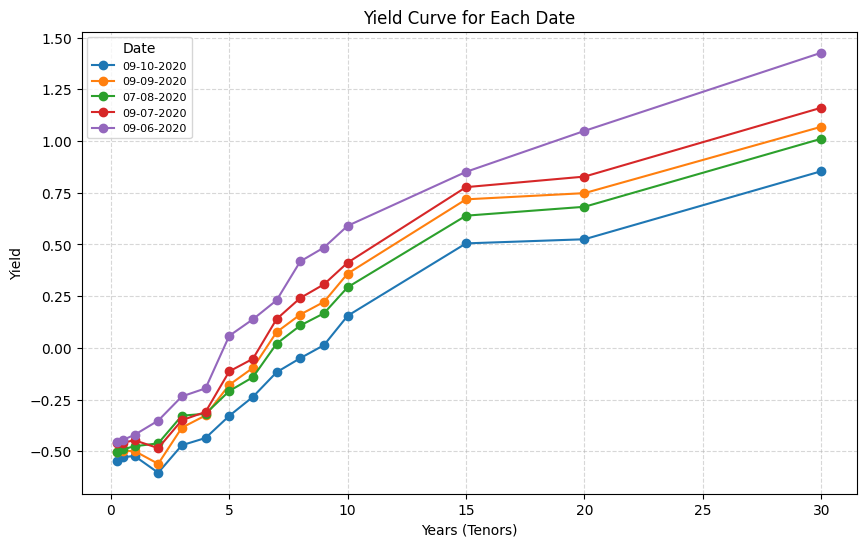

In [ ]:
# Plotting the yield curve for each date
plt.figure(figsize=(10, 6))
for date in df.columns:
    plt.plot(df.index, df[date], marker="o", label=date)

plt.xlabel("Years (Tenors)")
plt.ylabel("Yield")
plt.title("Yield Curve for Each Date")
plt.legend(title="Date", loc="upper left", fontsize=8)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

#### c) Estimate the NSS parameters for each date

In [ ]:
"https://medium.com/@pape14/understanding-the-nelson-siegel-svensson-nss-model-for-bond-yield-curve-analysis-2a23202cbf6b"

'https://medium.com/@pape14/understanding-the-nelson-siegel-svensson-nss-model-for-bond-yield-curve-analysis-2a23202cbf6b'

In [ ]:
# Define Nelson-Siegel-Svensson function
def NelsonSiegelSvensson(TimeVec, beta0, beta1, beta2, beta3, lambda0, lambda1):
    # Calculation of predicted yields using the NSS formula
    predicted_yield = beta0 + beta1 * (1 - np.exp(-TimeVec / lambda0)) / (TimeVec / lambda0) + \
                      beta2 * ((1 - np.exp(-TimeVec / lambda0)) / (TimeVec / lambda0) - np.exp(-TimeVec / lambda0)) + \
                      beta3 * ((1 - np.exp(-TimeVec / lambda1)) / (TimeVec / lambda1) - np.exp(-TimeVec / lambda1))
    return predicted_yield

# Function to minimize NSSGoodFit using scipy.optimize.minimize
def NSSMinimize(params, TimeVec, YieldVec):
    # Cost function for optimization
    def NSSGoodFit(params, TimeVec, YieldVec):
        beta0, beta1, beta2, beta3, lambda0, lambda1 = params
        predicted_yield = NelsonSiegelSvensson(TimeVec, beta0, beta1, beta2, beta3, lambda0, lambda1)
        residuals = predicted_yield - YieldVec
        return np.sum(residuals**2)

    # Call minimize with the "L-BFGS-B" method and a maximum number of iterations
    opt_sol = minimize(NSSGoodFit, params, args=(TimeVec, YieldVec), method="L-BFGS-B", options={'maxiter': 1000})
    return opt_sol.x

In [ ]:
# Initial parameters for optimization (might not be the best ones)
initial_params = (0.1, 0.1, 0.1, 0.1, 1.0, 1.0)

# Time Vector --> array of tenors in years
TimeVec = np.array(df.index)

# Iterating over each date to estimate the optimal NSS parameters and storing them in a dictionary
nss_parameters = {}
for date in df.columns:
    YieldVec = np.array(df[date])
    params = NSSMinimize(initial_params, TimeVec, YieldVec)
    nss_parameters[date] = params

nss_parameters

{'09-10-2020': array([ 1.22846335, -1.72025348, -1.52385246, -0.87919969,  3.02040941,
         2.76013107]),
 '09-09-2020': array([ 1.41046051, -1.86168909, -1.56563217, -1.10686317,  2.50586703,
         2.54327303]),
 '07-08-2020': array([ 1.41690519, -1.89352509, -1.45201286, -0.76986967,  3.16522509,
         3.16643305]),
 '09-07-2020': array([ 1.51044408, -1.91601517, -1.41523591, -1.30610574,  2.54223409,
         2.54345488]),
 '09-06-2020': array([ 1.82468414, -2.27136828, -1.40265685, -0.68445124,  3.4847894 ,
         1.98572179])}

Since we are optimizing all the parameters, the initial guess may condition the optimization result (local minima).
Here we chose a suitable initial guess but one alternative would be to try run optimization with several random initial guesses and keep the one with the minimum error.

#### d) Plot the NSS Yield Curve for each date

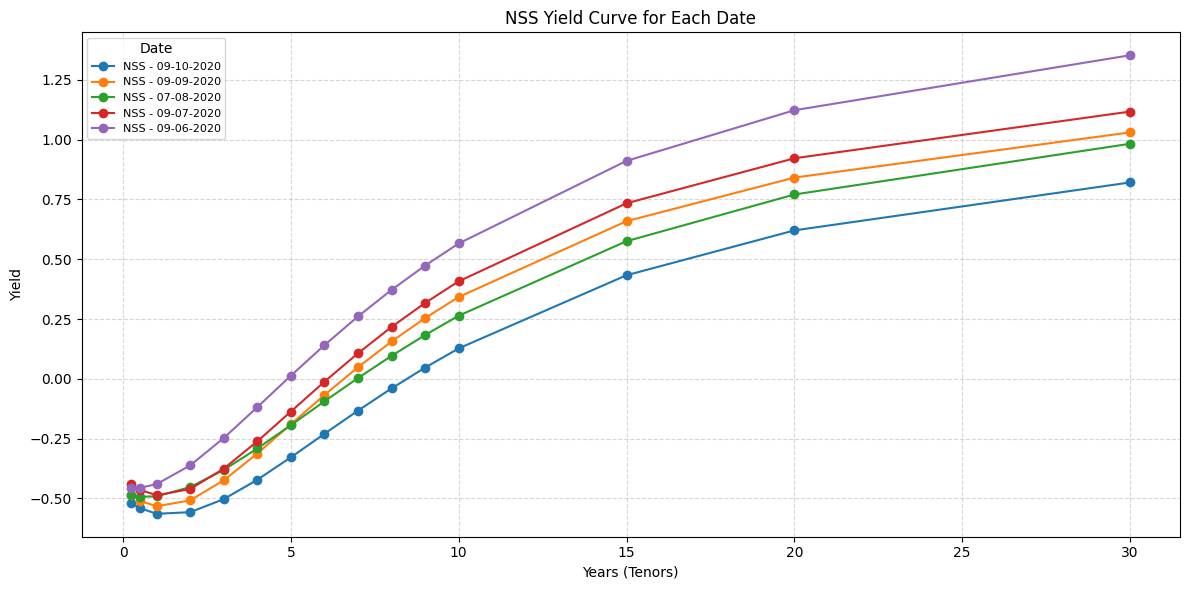

In [ ]:
# Plotting the NSS Yield Curve for each date
plt.figure(figsize=(12, 6))

for date in df.columns:
    # Retrieving the estimated NSS parameters for each date
    beta0, beta1, beta2, beta3, lambda0, lambda1 = nss_parameters[date]
    # Calculating the NSS yield curve using the estimated parameters
    nss_yield = NelsonSiegelSvensson(TimeVec, beta0, beta1, beta2, beta3, lambda0, lambda1)
    # Plotting the NSS yield curve of each specific date
    plt.plot(TimeVec, nss_yield, marker="o", label=f"NSS - {date}")

plt.xlabel("Years (Tenors)")
plt.ylabel("Yield")
plt.title("NSS Yield Curve for Each Date")
plt.legend(title="Date", loc="upper left", fontsize=8)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### e) Plot the evolution of the 9M, 3.5Y, 12.5Y and the 25Y rate over the curve dates (a line for each tenor)

{'9M': [], '3.5Y': [], '12.5Y': [], '25Y': []}
{'9M': [-0.5553182237145229, -0.5252658018676019, -0.49410361525054153, -0.47929747640983905, -0.45071770867444805], '3.5Y': [-0.46499493914278006, -0.3705823779599412, -0.33774317602561754, -0.3208392465626353, -0.18398323976271605], '12.5Y': [0.2988305613174903, 0.5233129138867698, 0.43766428775502464, 0.5940345560756215, 0.760340184905386], '25Y': [0.7400548882196735, 0.9544762076528228, 0.8968399406699158, 1.0389819628298467, 1.2596604654588348]}


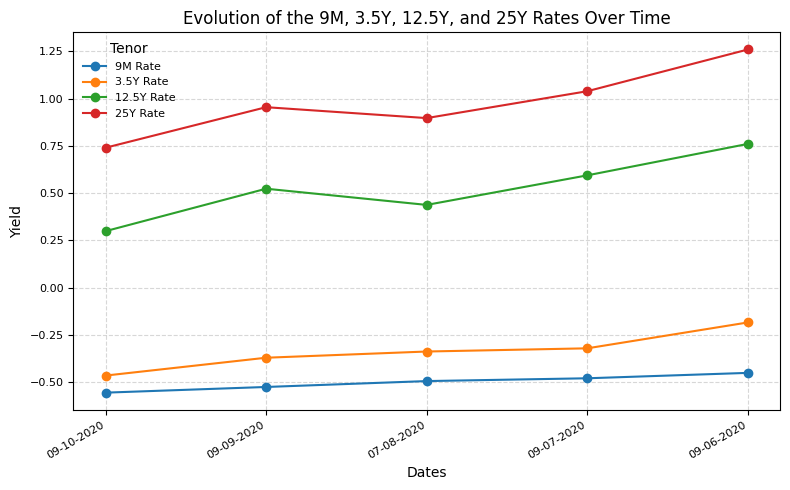

In [ ]:
#Converting the tenors into year fractions
tenors_to_plot = {"9M": 9 / 12, "3.5Y": 3.5, "12.5Y": 12.5, "25Y": 25.0}

# This dictionary will store the yield values for the tenors for all the dates
yields_evolution = {tenor: [] for tenor in tenors_to_plot}

# Calculating the yield values for each tenor using the NSS parameters for each date
for date, params in nss_parameters.items():
  beta0, beta1, beta2, beta3, lambda0, lambda1 = params
  # Predict the yields for each tenor
  for tenor_name, tenor_value in tenors_to_plot.items():
    yield_value = NelsonSiegelSvensson(np.array([tenor_value]), beta0, beta1, beta2, beta3, lambda0, lambda1)
    yields_evolution[tenor_name].append(yield_value[0])

# Plotting the evolution of the yields over time for each tenor
plt.figure(figsize=(8, 5))
for tenor_name, yields in yields_evolution.items():
    plt.plot(df.columns, yields, marker='o', label=f"{tenor_name} Rate

plt.xlabel("Dates")
plt.ylabel("Yield")
plt.title("Evolution of the 9M, 3.5Y, 12.5Y, and 25Y Rates Over Time")
plt.xticks(rotation=30, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title="Tenor", loc="upper left", fontsize=8, frameon=False)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

#### f) Plot the market data points vs the NSS fit for each date using 5 subplots sharing the y axis (One market date in each subplot)

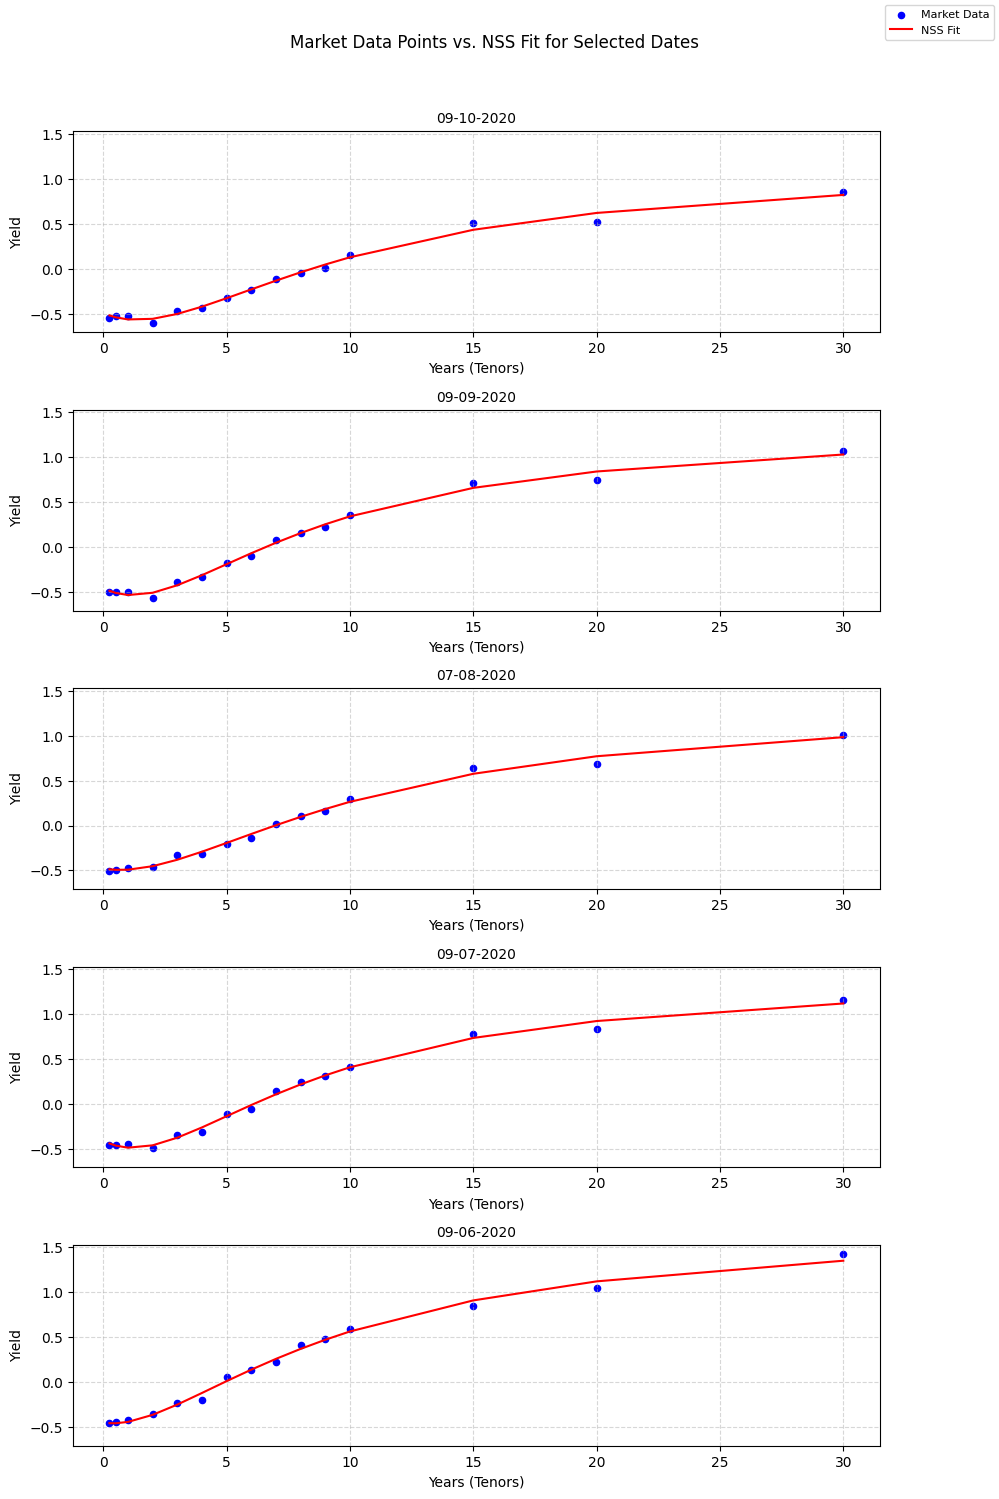

In [ ]:
# Number of subplots
num_subplots = 5

# Store the dates to plot
dates_to_plot = [df.columns[i] for i in range(5)]

# Creating the Subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 15), sharey=True)
fig.suptitle("Market Data Points vs. NSS Fit for Selected Dates", fontsize=12)

# Iterating through the dates and plotting market data vs NSS fit
for i, date in enumerate(dates_to_plot):
    # Market data --> yield values from the original transposed dataframe
    market_yields = df[date].values

    # Getting the NSS fit using the predicted parameters
    beta0, beta1, beta2, beta3, lambda0, lambda1 = nss_parameters[date]
    nss_yield = NelsonSiegelSvensson(TimeVec, beta0, beta1, beta2, beta3, lambda0, lambda1)

    # Plotting the market data points
    axes[i].scatter(TimeVec, market_yields, color='blue', label='Market Data', s=20)
    # Plotting NSS fit curve
    axes[i].plot(TimeVec, nss_yield, color='red', label='NSS Fit')

    axes[i].set_title(date, fontsize=10)
    axes[i].set_xlabel("Years (Tenors)")
    axes[i].set_ylabel("Yield")
    axes[i].grid(visible=True, linestyle='--', alpha=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=8)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])

plt.show()

#### g) Make a function that will give the daycount fraction between two dates for either convention Act/360 or Act/365 using date strings as inputs

Example: dayCount('15-06-2020', '15-12-2021', 'Act/360')

In [ ]:
"actual/360 - calculates the daily interest using a 360-day year and then multiplies that by the actual number of days in each time period."
"actual/365 - calculates the daily interest using a 365-day year and then multiplies that by the actual number of days in each time period."

def dayCount(start_date, end_date, convention):
    # Converting the date strings to datetime objects
    start = datetime.strptime(start_date, "%d-%m-%Y")
    end = datetime.strptime(end_date, "%d-%m-%Y")

    # Calculating the actual number of days between the input dates
    days_difference = (end - start).days

    # Calculateing the day count fraction based on the selected convention (Act/360 or Act/365)
    if convention == 'Act/360':
        day_count_fraction = days_difference / 360
    elif convention == 'Act/365':
        day_count_fraction = days_difference / 365
    else:
        raise ValueError("This convention is not valid. Use 'Act/360' or 'Act/365'.")

    return day_count_fraction

# Testing two examples --> One for each convention
print(dayCount('15-06-2020', '15-12-2021', 'Act/360'))
print(dayCount('15-06-2020', '15-12-2021', 'Act/365'))

1.5222222222222221
1.5013698630136987


#### h) Make a function that not only returns the present value of a future investment for a given rate but also prints a custom string. Use it to determine the present value of a payment of EUR 2,430.04 in 5 years at the rate of 5% (Annual compounded rate) and print whatever string you want

Ex: pv(amount, rate, maturity, text)

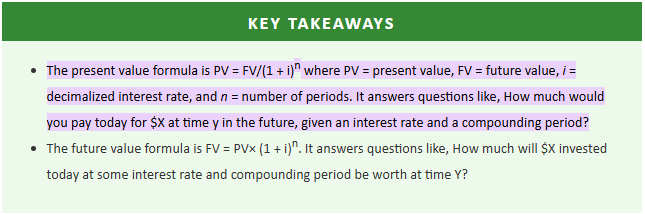

In [ ]:
"https://saylordotorg.github.io/text_money-and-banking-v2.0/s07-02-present-and-future-value.html#:~:text=The%20present%20value%20formula%20is,rate%20and%20a%20compounding%20period%3F"

def pv(amount, rate, maturity, text):
    # Calculating the present values of a future investment considering the following formula
    present_value = amount / ((1 + rate) ** maturity)

    # Print the custom string
    print(text)

    # Return the present value
    return present_value

# Testing the function
custom_text = "This is just a simple example."
pv_value = pv(2430.04, 0.05, 5, custom_text)

print(f"The present value of your future investment: {round(pv_value, 2)} EUR")

This is just a simple example.
The present value of your future investment: 1904.0 EUR
